作法
1. 4003弄成book,user都有autoencoder，各16維
    + 這部分和評分相關係數有點慘...
2. 把前半部分直到`df_total_features`的結果讀進來
3. 調lightgbm的參數（`b04.LightGBMRegressorTuner`類別）
    + 隨機調參從常態分配抽出，詳見`utils.draw`
    + `'num_leaves'        : int(draw(15,   127,  3,     1023))`
    + `'learning_rate'     :     draw(1e-3, 1e+2, 1e-10, 1e+5, log=True)`
    + `'n_estimators'      : int(draw(50,   500,  1,     1000))`
    + `'min_child_samples' : int(draw(15,   63,   7,     1023))`
4. 把工作站上調出來最好的參數人工輸到這篇ipynb上跑 :p

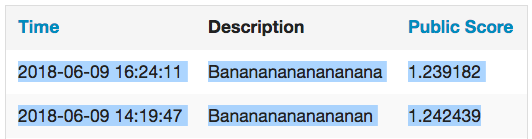

結論
1. 本地CV較優的看起來Public Score也不錯
2. bias-variance issue
    + 可以把調參的參數-Score表格用動態圖表畫出來，看看哪些參數影響bias、哪些variance比較低
3. 對lightgbm來說參數對訓練時間影響不算非常敏感
    + 每個模型訓練時間平均6.152806 標準差4.459648（秒）
    + 之後調Neural Network這部分就要非常小心了

【可能的方向們】
1. **Books**
    1. 把作者、出版社整理成類別資料
        + lightgbm可以處理missing value：[Parameters (Ctrl+F "missing")](http://lightgbm.readthedocs.io/en/latest/Parameters.html)
    2. 以出版社為中心作分群（Publisher2Vec）
    3. 從ISBN找出特徵
        + 例如0開頭是美國
        + 如果不是10碼/13碼標準格式，這格特徵乾脆列missing value
2. **Users**
    1. 居住地
        1. 經緯度（也就是之前聖福抓的）
        2. 把城市,州,國整理成類別資料
    2. 年齡資料填缺（書本出版年也同理）
        + 另開一欄特徵「原始是不是missing value」
        + 用knn一類較為簡單的ML方法把年齡預測值當成填缺值
            + 關鍵字：knn missing value imputation
3. **Models**
    1. unsupervised轉成特徵
        1. K-Means
        2. Matrix Factorization
        3. Variational AutoEncoder
    2. logistic regression
        1. 1-10分作為10種獨立類別（可能要注意類別不平衡）
        2. 1-10分作10次二元分類，不小於10分、9分、...
    3. neural network

In [150]:
import learning2read
learning2read.reload_all()
from learning2read.b04 import *

> 其實我已經忘記`P6_6.pk`具體是從哪裡生出來的了，對不起QQ

In [127]:
P6 = load_pickle(File("P6_6.pk"))
# globals().update(P6.var)
P6.var.keys()

dict_keys(['raw_train', 'raw_test', 'raw_implicit', 'df_total', 'user_rating', 'book_rating', 'book_vector', 'user_vector', 'df_total_features', 'df_train'])

調參都在`linux10`上跑完囉 :p

In [145]:
# obj = LightGBMRegressorTuner.tune1(
#     P6.var['df_train'],
#     T=3,
#     name="tune1",
#     path_mgr=PathMgr("/tmp/")
# )

# Param1

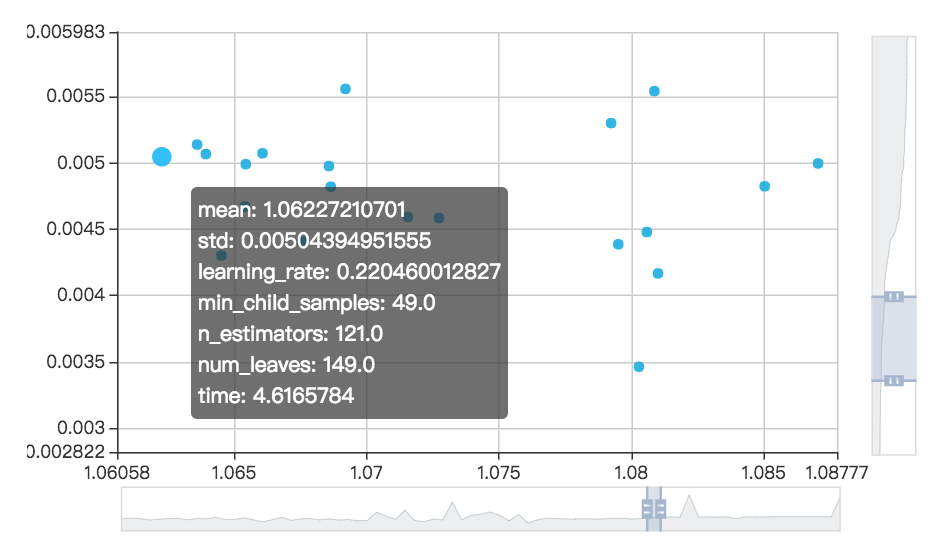

In [152]:
procedure4006 = [
    {
        'class'  : 'learning2read.preprocessing.RowFilter',
        'output' : 'df_train',
        'input_data' : 'df_total_features',
        'func' : r"lambda df : df['Book-Rating']>0",
    },
    {
        'class'  : 'learning2read.b04.LightGBMRegressor',
        'output' : 'model_lgbm',
        'input_data' : 'df_train',
        'param' : { # tune by linux10
            'num_leaves' : 149,
            'learning_rate' : 0.220460,
            'n_estimators' : 121,
            'min_child_samples' : 49,
            'seed' : 1,
        }
    },
    {
        'class'  : 'learning2read.preprocessing.RowFilter',
        'output' : 'df_test',
        'input_data' : 'df_total_features',
        'func' : r"lambda df : df['Book-Rating']<0",
    },
    {
        'class'  : 'learning2read.submission.Track1',
        'output' : 'track1',
        'input_data' : ['df_test', 'model_lgbm'],
    },
    {
        'class'  : 'learning2read.submission.Track2',
        'output' : 'track2',
        'input_data' : ['df_test', 'model_lgbm'],
    },
]

In [153]:
from learning2read.proc import Procedure
P4006 = Procedure(procedure4006,True)
P4006.load_data({
    'df_total_features': P6.var['df_total_features']
})
P4006.run()

run_id(0): {'class': 'learning2read.preprocessing.RowFilter', 'output': 'df_train', 'input_data': 'df_total_features', 'func': "lambda df : df['Book-Rating']>0"}
run_id(1): {'class': 'learning2read.b04.LightGBMRegressor', 'output': 'model_lgbm', 'input_data': 'df_train', 'param': {'num_leaves': 149, 'learning_rate': 0.22046, 'n_estimators': 121, 'min_child_samples': 49, 'seed': 1}}
run_id(2): {'class': 'learning2read.preprocessing.RowFilter', 'output': 'df_test', 'input_data': 'df_total_features', 'func': "lambda df : df['Book-Rating']<0"}
run_id(3): {'class': 'learning2read.submission.Track1', 'output': 'track1', 'input_data': ['df_test', 'model_lgbm']}
run_id(4): {'class': 'learning2read.submission.Track2', 'output': 'track2', 'input_data': ['df_test', 'model_lgbm']}


In [157]:
pd.DataFrame(P4006.var['track1']).to_csv(File('track1_lgbm_tuned.csv'),header=None,index=None)

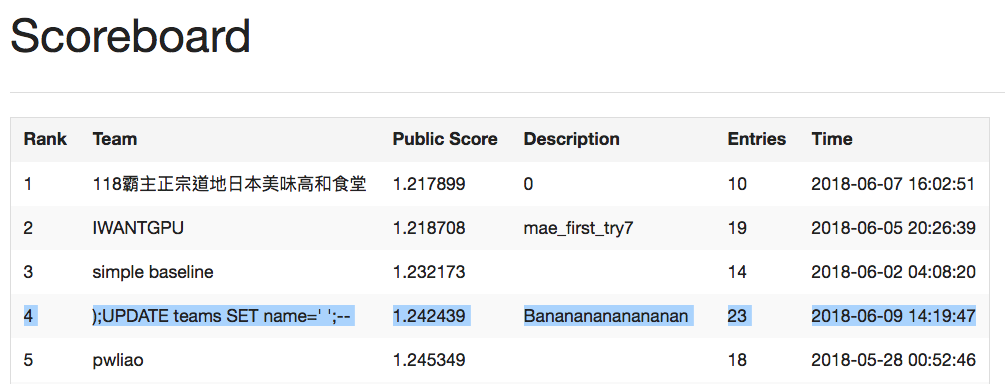

# Param2

In [162]:
procedure4006_2 = procedure4006[:]
procedure4006_2[1]['param'].update({
    'num_leaves': 151,
    'learning_rate': 0.042625,
    'n_estimators': 295,
    'min_child_samples': 61,
    'seed': 1
})
P4006_2 = Procedure(procedure4006_2,True)
P4006_2.load_data({
    'df_total_features': P6.var['df_total_features']
})
P4006_2.run()

run_id(0): {'class': 'learning2read.preprocessing.RowFilter', 'output': 'df_train', 'input_data': 'df_total_features', 'func': "lambda df : df['Book-Rating']>0"}
run_id(1): {'class': 'learning2read.b04.LightGBMRegressor', 'output': 'model_lgbm', 'input_data': 'df_train', 'param': {'num_leaves': 151, 'learning_rate': 0.042625, 'n_estimators': 295, 'min_child_samples': 61, 'seed': 1}}
run_id(2): {'class': 'learning2read.preprocessing.RowFilter', 'output': 'df_test', 'input_data': 'df_total_features', 'func': "lambda df : df['Book-Rating']<0"}
run_id(3): {'class': 'learning2read.submission.Track1', 'output': 'track1', 'input_data': ['df_test', 'model_lgbm']}
run_id(4): {'class': 'learning2read.submission.Track2', 'output': 'track2', 'input_data': ['df_test', 'model_lgbm']}


In [163]:
pd.DataFrame(P4006_2.var['track1']).to_csv(File('track1_lgbm_tuned_2_059275.csv'),header=None,index=None)

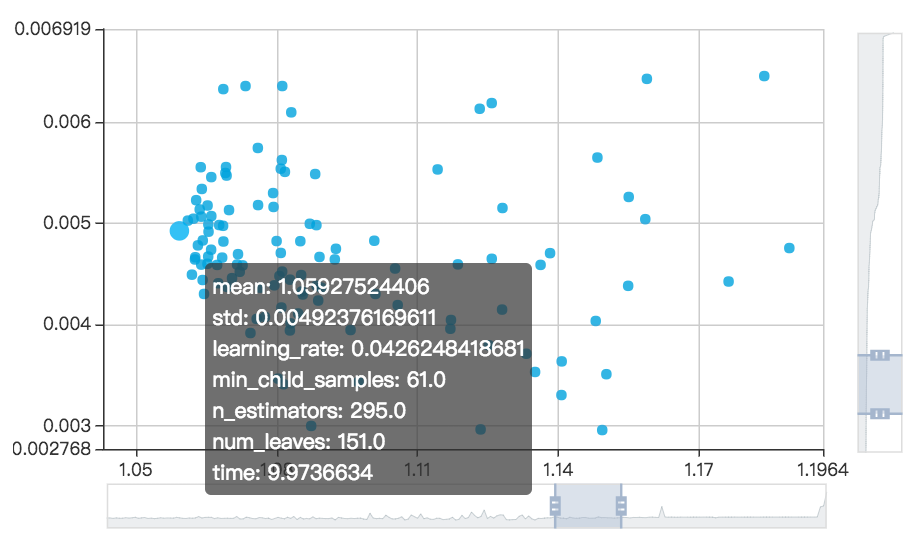

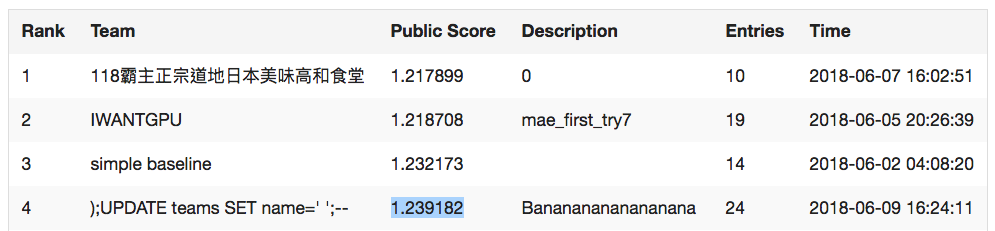

In [10]:
import homework
from homework import *
reload(homework)
pass

<IPython.core.display.Javascript object>

$\def \t {\text}
\def \sp {\space}
\def \spc {\space\space\space}
\def \spe {\space\space\space\space\space}
\def \bc {\because}
\def \A {\mathcal{A}}
\def \H {\mathcal{H}}
\def \m {\mathcal{m}}
\def \R {\mathbb{R}}
\def \N {\mathbb{N}}
\def \Z {\mathbb{Z}}
\def \Q {\mathbb{Q}}
\def \C {\mathbb{C}}
\def \say {\underbrace}
\def \L {\mathbb{L}}
\def \P {\mathbb{P}}
\def \F {\mathbb{F}}
\def \sbc {\spc\because}
\def \sbe {\spe\because}
\def \defeq {\overset{def}{=}}
\def \ctr {\rightarrow\leftarrow}
\def \st {\t{ such that }}
\def \inner#1 #2{\langle #1 \mid #2 \rangle}
\def \norm#1{\lVert #1 \rVert}
\def \bm#1 {\begin{bmatrix} #1 \end{bmatrix}}
\def \pt {\partial}
\def \ppt#1 #2{\frac{\pt #1}{\pt #2}}
\def\l {\mathscr{l}}
\def \vphi {\varphi}$
